## Music Generation using WaveNet

Approach for automatic music generation based on the WaveNet

The building blocks of WaveNet are **Causal Dilated 1D Convolution layers**.

### The Workflow of WaveNet:

  * Input is fed into a causal 1D convolution
  * The output is then fed to 2 different dilated 1D convolution layers with sigmoid and tanh activations
  *  The element-wise multiplication of 2 different activation values results in a skip connection
  *  And the element-wise addition of a skip connection and output of causal 1D results in the residual

In [ ]:
import tensorflow as tf

### Running this script using GPU is recommended

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import random
import matplotlib.pyplot as plt #library for visualiation
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.models import load_model

import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Listing current data on our folder.
import os
print(os.listdir("."))

['.config', 'sample_data']


`music21` is a Toolkit for Computer-Aided Musicology and Symbolic Music Data. It was developed at MIT.
We will use this for understaning our music.

In [ ]:
pip install music21

     |████████████████████████████████| 19.2 MB 9.8 MB/s eta 0:00:01
  Created wheel for music21: filename=music21-6.7.1-py3-none-any.whl size=21941692 sha256=1196adaf1c59dbc61972be5f69b6598a957a16d439d0a519305cba2c91daadf0
  Stored in directory: /root/.cache/pip/wheels/72/44/61/90e4e65262ca1b4d9f707527b540729ce3f64e00fc6b38d54c
Successfully built music21
Note: you may need to restart the kernel to use updated packages.


## Loading the dataset

MIDI is a standard format for storing music files. MIDI stands for Musical Instrument Digital Interface. MIDI files contain the instructions rather than the actual audio. Hence, it occupies very little memory. That’s why it is usually preferred while transferring files.

In [ ]:
#library for understanding music
from music21 import *
def read_midi(file):

    print("Loading Music File:",file)

    notes=[]
    notes_to_parse = None

    #parsing a midi file
    midi = converter.parse(file)

    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:

        #select elements of only piano
        if 'Piano' in str(part):

            notes_to_parse = part.recurse()

            #finding whether a particular element is note or a chord
            for element in notes_to_parse:

                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))

                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [ ]:
#specify the path
#path='../input/maestropianomidi/maestro-v3.0.0/2018/'
path = '../input/beethoven-midi/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: ../input/beethoven-midi/beethoven_opus22_3.mid
Loading Music File: ../input/beethoven-midi/pathetique_1.mid
Loading Music File: ../input/beethoven-midi/beethoven_opus22_2.mid
Loading Music File: ../input/beethoven-midi/waldstein_2.mid
Loading Music File: ../input/beethoven-midi/beethoven_opus22_4.mid
Loading Music File: ../input/beethoven-midi/beethoven_hammerklavier_4.mid
Loading Music File: ../input/beethoven-midi/mond_3.mid
Loading Music File: ../input/beethoven-midi/appass_1.mid
Loading Music File: ../input/beethoven-midi/elise.mid
Loading Music File: ../input/beethoven-midi/appass_3.mid
Loading Music File: ../input/beethoven-midi/pathetique_2.mid
Loading Music File: ../input/beethoven-midi/beethoven_opus90_1.mid
Loading Music File: ../input/beethoven-midi/beethoven_hammerklavier_2.mid
Loading Music File: ../input/beethoven-midi/beethoven_hammerklavier_3.mid
Loading Music File: ../input/beethoven-midi/beethoven_hammerklavier_1.mid
Loading Music File: ../input/be

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


## Preprocessing

In [ ]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

280


(array([196.,  31.,  10.,   8.,   7.,  10.,   5.,   9.,   2.,   2.]),
 array([1.0000e+00, 2.3970e+02, 4.7840e+02, 7.1710e+02, 9.5580e+02,
        1.1945e+03, 1.4332e+03, 1.6719e+03, 1.9106e+03, 2.1493e+03,
        2.3880e+03]),
 <BarContainer object of 10 artists>)

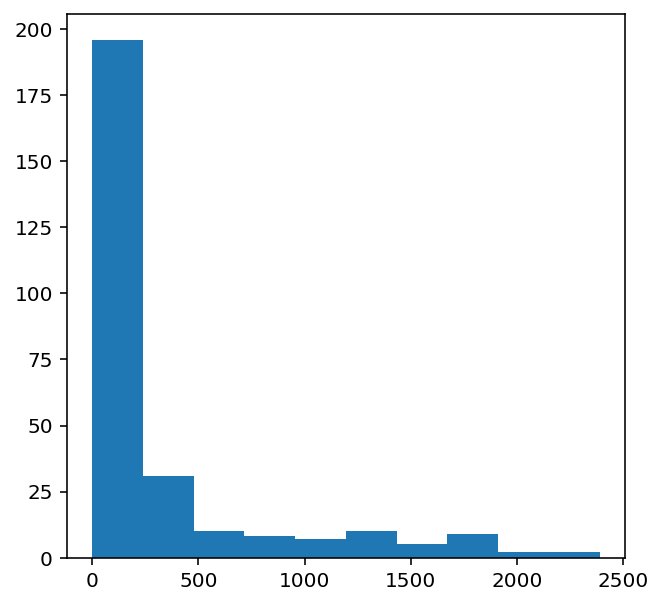

In [ ]:
#computing frequency of each note
freq = dict(Counter(notes_))

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

In [ ]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

150


In [ ]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)
    new_music.append(temp)

new_music = np.array(new_music)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):

        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]

        x.append(input_)
        y.append(output)

x=np.array(x)
y=np.array(y)

In [ ]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [ ]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)

x_seq = np.array(x_seq)

In [ ]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y))
y_seq=np.array([y_note_to_int[i] for i in y])

In [ ]:
#train test split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

## Defining Model

First, we will use the wavenet architecture for generation.

### Using Wavenet

In [ ]:
K.clear_session()
model = Sequential()

#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True))

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

#model.add(Conv1D(256,5,activation='relu'))
model.add(GlobalMaxPool1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           15000     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            19264     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

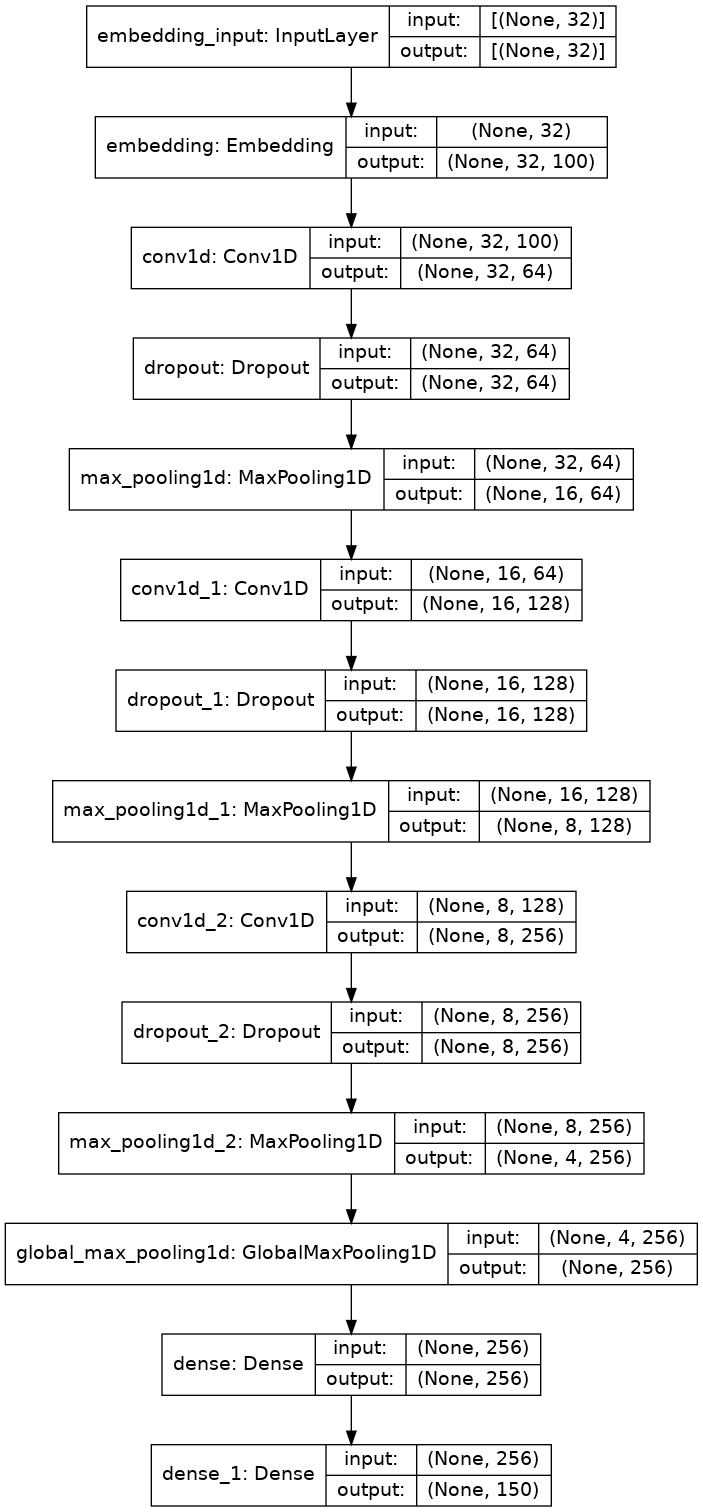

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1)#, callbacks=[mc])

Epoch 1/50
524/524 [==============================] - 11s 11ms/step - loss: 4.3614 - val_loss: 3.8732
Epoch 2/50
524/524 [==============================] - 5s 9ms/step - loss: 3.6746 - val_loss: 3.6402
Epoch 3/50
524/524 [==============================] - 5s 10ms/step - loss: 3.5064 - val_loss: 3.5730
Epoch 4/50
524/524 [==============================] - 5s 10ms/step - loss: 3.3927 - val_loss: 3.4743
Epoch 5/50
524/524 [==============================] - 5s 9ms/step - loss: 3.3059 - val_loss: 3.4378
Epoch 6/50
524/524 [==============================] - 5s 10ms/step - loss: 3.2343 - val_loss: 3.3653
Epoch 7/50
524/524 [==============================] - 5s 9ms/step - loss: 3.1878 - val_loss: 3.3136
Epoch 8/50
524/524 [==============================] - 5s 10ms/step - loss: 3.1298 - val_loss: 3.3026
Epoch 9/50
524/524 [==============================] - 5s 9ms/step - loss: 3.0744 - val_loss: 3.2851
Epoch 10/50
524/524 [==============================] - 5s 10ms/step - loss: 3.0442 - val_loss:

In [ ]:
#checkpoint
mc=ModelCheckpoint('model_wavenet.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [ ]:
model.save('model_wavenet.h5')
print('Wavenet model saved')

Wavenet model saved


In [ ]:
#loading best model
model = load_model('model_wavenet.h5')

## Make predictions

In [ ]:
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]

print(predictions)

[69, 13, 69, 69, 13, 13, 13, 13, 13, 13]


In [ ]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x))
predicted_notes = [x_int_to_note[i] for i in predictions]

## Converting back to MIDI

In [ ]:
def convert_to_midi(prediction_output):

    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:

        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:

                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)

            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)

        # pattern is a note
        else:

            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music_wavenet.mid')

In [ ]:
convert_to_midi(predicted_notes)

We have generated a 'music_wavenet.mid' file which is an is a piano tune generated using wavenet on the dataset.

## Using LSTM

In [ ]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(x_val, y_val, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

In [ ]:
K.clear_session()
model2 = Sequential()
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True))
model2.add(LSTM(128,return_sequences=True))
model2.add(LSTM(128))
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(Dense(len(unique_x)))
model2.add(Activation('softmax'))
model.build(input_shape)
model2.summary()
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

mc2=ModelCheckpoint('lstm_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

history = model2.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc2])

Code Output
 WaveNet Model Training Output:
Epoch 1/50
300/300 [==============================] - 30s 100ms/step - loss: 3.5 - val_loss: 3.1
Epoch 2/50
300/300 [==============================] - 28s 95ms/step - loss: 3.0 - val_loss: 2.8
LSTM Model Training Output
Epoch 1/50
300/300 [==============================] - 20s 75ms/step - loss: 3.8 - val_loss: 3.3
Epoch 2/50
300/300 [==============================] - 18s 70ms/step - loss: 3.4 - val_loss: 3.1
 Predicted Notes for Generated Music
Predicted Notes (WaveNet): ['C4', 'E4', 'G4', 'C5', 'D5', 'F4', 'A4', 'G4', ...]
Predicted Notes (LSTM): ['E4', 'D4', 'F4', 'C5', 'B4', 'G4', 'D5', 'A4', ...]
  Generated MIDI File
	The code saves the generated music to a MIDI file:
	WaveNet model output: wavenet_music.mid
	LSTM model output: lstm_music.mid
	You can play back these MIDI files using any MIDI-compatible software (e.g., MuseScore, GarageBand, or online MIDI players).
